## First stage - ACOUSTIC

In [1]:
#https://zhuanlan.zhihu.com/p/358241055

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
source_df = pd.read_csv('Training Dataset/training datalist.csv')
source_df['wav_path'] = source_df['ID'].map("Training Dataset/training_voice_data/{}.wav".format)
source_df_train1, source_df_train2 = train_test_split(source_df, test_size = 0.6, random_state = 33)

In [4]:
# Counter(source_df['Disease category'])
# Counter({1: 536, 2: 220, 3: 168, 5: 32, 4: 44})

In [5]:
source_df_train1

,ID,Sex,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,...,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,wav_path
129,1100nun,1,31,1,1,0,1,1,0,0,...,3,1,0,0,0,0,0,0,22.0,Training Dataset/training_voice_data/1100nun.wav
757,0H02j6q,2,51,5,0,0,1,1,1,0,...,1,2,0,0,0,0,0,0,26.0,Training Dataset/training_voice_data/0H02j6q.wav
770,11024i9,2,31,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,14.0,Training Dataset/training_voice_data/11024i9.wav
198,110223m,2,39,1,1,0,0,1,0,0,...,2,1,0,0,0,0,0,0,23.0,Training Dataset/training_voice_data/110223m.wav
610,0702nct,1,59,3,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0.0,Training Dataset/training_voice_data/0702nct.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,0M017jq,2,40,3,1,1,0,0,0,0,...,2,1,0,0,0,0,0,0,38.0,Training Dataset/training_voice_data/0M017jq.wav
578,0002m5r,1,76,2,1,1,1,0,0,0,...,1,4,0,1,1,0,0,0,29.0,Training Dataset/training_voice_data/0002m5r.wav
728,1001vhk,1,37,1,1,0,1,1,0,0,...,2,1,0,0,0,0,0,0,14.0,Training Dataset/training_voice_data/1001vhk.wav
391,120200g,2,50,1,0,0,1,1,1,0,...,1,1,0,0,0,0,0,0,22.0,Training Dataset/training_voice_data/120200g.wav


In [6]:
# 讀取訓練資料集表單
df = source_df_train1[['Disease category', 'wav_path']]
df = df.reset_index()

In [7]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)

    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
          # Nothing to do
          return aud

        if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
        else:
          # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])

        return ((resig, sr))
    
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
          # Nothing to do
          return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
          # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
          # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)
    
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

In [8]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path, mode = 'train'):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4
        self.mode = mode

        # ----------------------------
        # Number of items in dataset
        # ----------------------------
    def __len__(self):
        return len(self.df)    

    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
        if self.mode == 'train':
            audio_file = self.data_path + self.df.loc[idx, 'wav_path']
            # Get the Class ID
            class_id = self.df.loc[idx, 'Disease category']

            aud = AudioUtil.open(audio_file)
            # Some sounds have a higher sample rate, or fewer channels compared to the
            # majority. So make all sounds have the same number of channels and same 
            # sample rate. Unless the sample rate is the same, the pad_trunc will still
            # result in arrays of different lengths, even though the sound duration is
            # the same.
            reaud = AudioUtil.resample(aud, self.sr)
            rechan = AudioUtil.rechannel(reaud, self.channel)

            dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
            shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
            sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
            aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

            return aug_sgram, class_id
        else:
            audio_file = self.data_path + self.df.loc[idx, 'wav_path']
            aud = AudioUtil.open(audio_file)
            reaud = AudioUtil.resample(aud, self.sr)
            rechan = AudioUtil.rechannel(reaud, self.channel)

            dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
            shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
            sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
            aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

            return aug_sgram

In [9]:
from torch.utils.data import random_split
data_path = ''
myds = SoundDS(df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [10]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)
        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        # Linear layer
        x = self.lin(x)
        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
# Check that it is on Cuda
# next(myModel.parameters())

In [11]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0035)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
    best_result = 0
    stopping_step = 0
    early_stopping_patience = 15
    
    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0], data[1]
            # print(inputs)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # print(prediction)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        
        if acc > best_result:
            best_result = acc
            stopping_step = 0
        else:
            stopping_step += 1
            if stopping_step >= early_stopping_patience:
                print('Early stopping triggered.')
                break
                
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
    print('Finished Training')

In [12]:
num_epochs=40   # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 2.31, Accuracy: 0.06
Epoch: 1, Loss: 2.29, Accuracy: 0.12
Epoch: 2, Loss: 2.25, Accuracy: 0.24
Epoch: 3, Loss: 2.21, Accuracy: 0.32
Epoch: 4, Loss: 2.15, Accuracy: 0.42
Epoch: 5, Loss: 2.08, Accuracy: 0.45
Epoch: 6, Loss: 2.01, Accuracy: 0.46
Epoch: 7, Loss: 1.91, Accuracy: 0.49
Epoch: 8, Loss: 1.76, Accuracy: 0.52
Epoch: 9, Loss: 1.60, Accuracy: 0.56
Epoch: 10, Loss: 1.45, Accuracy: 0.55
Epoch: 11, Loss: 1.31, Accuracy: 0.55
Epoch: 12, Loss: 1.21, Accuracy: 0.55
Epoch: 13, Loss: 1.15, Accuracy: 0.58
Epoch: 14, Loss: 1.13, Accuracy: 0.60
Epoch: 15, Loss: 1.06, Accuracy: 0.60
Epoch: 16, Loss: 1.05, Accuracy: 0.60
Epoch: 17, Loss: 1.03, Accuracy: 0.61
Epoch: 18, Loss: 1.01, Accuracy: 0.60
Epoch: 19, Loss: 1.00, Accuracy: 0.62
Epoch: 20, Loss: 1.01, Accuracy: 0.62
Epoch: 21, Loss: 1.03, Accuracy: 0.59
Epoch: 22, Loss: 0.97, Accuracy: 0.62
Epoch: 23, Loss: 0.96, Accuracy: 0.62
Epoch: 24, Loss: 0.96, Accuracy: 0.63
Epoch: 25, Loss: 0.95, Accuracy: 0.66
Epoch: 26, Loss: 0.95,

In [13]:
import numpy as np
def inference (model, val_dl, mode = 'train_test'): 
    correct_prediction = 0 
    total_prediction = 0 
    ls = []
    # Disable gradient updates 
    with torch.no_grad(): 
        for data in val_dl: 
            # Get the input features and target labels, and put them on the GPU 
            inputs, labels = data[0], data[1]
            l = labels.tolist()

            # Normalize the inputs 
            inputs_m, inputs_s = inputs.mean(), inputs.std() 
            inputs = (inputs - inputs_m) / inputs_s 

            # Get predictions 
            # print(inputs)
            outputs = model(inputs) 

            # Get the predicted class with the highest score 
            _, prediction = torch.max(outputs,1) 
            p = prediction.tolist()
            if mode == 'train_test':
                correct_prediction += (prediction == labels).sum().item() 
                total_prediction += prediction.shape[0] 
                acc = correct_prediction/total_prediction 
                print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}') 
            else:
                ls.append(prediction)
                return ls
    # Run inference on trained model with the validation set 

In [14]:
inference(myModel, val_dl)

Accuracy: 0.56, Total items: 16
Accuracy: 0.53, Total items: 32
Accuracy: 0.60, Total items: 48
Accuracy: 0.53, Total items: 64
Accuracy: 0.54, Total items: 80


## XGboost - MEDICAL

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.utils import shuffle

In [16]:
#https://ithelp.ithome.com.tw/articles/10273094
from xgboost import XGBClassifier
xgboostModel = XGBClassifier() #n_estimators=35, learning_rate= 0.25

In [17]:
df2 = source_df_train1
col = [i for i in df2.columns if i not in ['ID','Disease category', 'wav_path']]

x = df2[col]
y = df2[['Disease category']]-1
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 33)

In [18]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start=20, stop=100, num=10)]
max_depth = [int(x) for x in np.linspace(4, 20, num=7)]
max_depth.append(None)
learning_rate=[round(float(x),2) for x in np.linspace(start=0.05, stop=0.35, num=10)]
colsample_bytree =[round(float(x),2) for x in np.linspace(start=0.1, stop=1, num=10)]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'colsample_bytree': colsample_bytree}
xg_random = RandomizedSearchCV(estimator = xgboostModel, param_distributions=random_grid,
                              n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

xg_random.fit(x_train,y_train)
xg_random.best_params_ 

from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
xgboostModel = xg_random.best_estimator_
med_model = xgboostModel.fit(x_train, y_train, sample_weight = sample_weight)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [19]:
from sklearn.utils.class_weight import compute_sample_weight
# sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
# med_model = xgboostModel.fit(x_train, y_train, sample_weight = sample_weight)

train:  0.925
test:  0.525


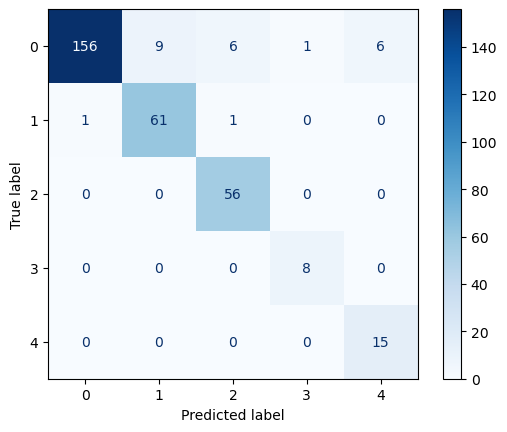

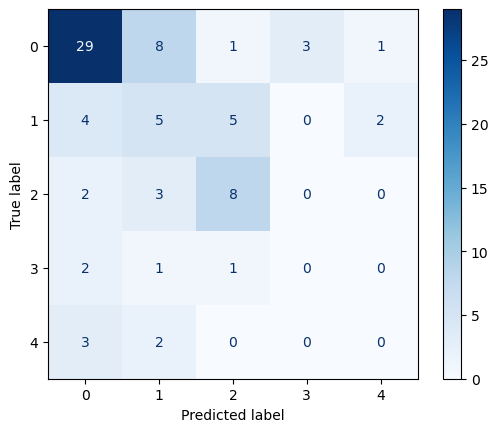

In [20]:
print('train: ',med_model.score(x_train, y_train))
pred = med_model.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train, pred)).plot(cmap='Blues')

print('test: ',med_model.score(x_test, y_test))
pred = med_model.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot(cmap='Blues')

## TWO stage

In [21]:
training_df, test_df = train_test_split(source_df_train2, test_size=0.2, random_state=55)

### train

In [22]:
df = training_df[['Disease category', 'wav_path']]
df = df.reset_index()
train_data_for_ac = SoundDS(df, data_path)
train_data_for_ac = torch.utils.data.DataLoader(train_data_for_ac, batch_size=750, shuffle=False)
ac_ls = inference(myModel, train_data_for_ac , mode='two_stage')
ac_ls = ac_ls[0].tolist()

In [23]:
col = [i for i in training_df.columns if i not in ['ID','Disease category', 'wav_path']]
train_data_for_med = training_df[col]
train_y_for_med = training_df[['Disease category']]-1
pred_ls = med_model.predict(train_data_for_med)

In [24]:
df_new = training_df
dfac = pd.DataFrame(ac_ls, columns = ['aco_pred'])
dfac = pd.concat([dfac, pd.DataFrame(df_new.reset_index()['index'], columns = ['index'])], axis=1)
dfac = dfac.set_index('index')

dfmd = pd.DataFrame(pred_ls, columns = ['med_pred'])
dfmd = pd.concat([dfmd, pd.DataFrame(df_new.reset_index()['index'], columns = ['index'])], axis=1)
dfmd = dfmd.set_index('index')

import pandas as pd
result = pd.concat([df_new, dfac , dfmd],axis=1)

### test

In [25]:
df = test_df[['Disease category', 'wav_path']]
df = df.reset_index()
test_data_for_ac = SoundDS(df, data_path)
test_data_for_ac = torch.utils.data.DataLoader(test_data_for_ac, batch_size=750, shuffle=False)
ac_ls = inference(myModel, test_data_for_ac , mode='two_stage')
ac_ls_test = ac_ls[0].tolist()

In [26]:
col = [i for i in test_df.columns if i not in ['ID','Disease category', 'wav_path']]
test_data_for_med = test_df[col]
test_y_for_med = test_df[['Disease category']]-1
pred_ls_test = med_model.predict(test_data_for_med)

In [27]:
df_new = test_df
dfac = pd.DataFrame(ac_ls_test, columns = ['aco_pred'])
dfac = pd.concat([dfac, pd.DataFrame(df_new.reset_index()['index'], columns = ['index'])], axis=1)
dfac = dfac.set_index('index')

dfmd = pd.DataFrame(pred_ls_test, columns = ['med_pred'])
dfmd = pd.concat([dfmd, pd.DataFrame(df_new.reset_index()['index'], columns = ['index'])], axis=1)
dfmd = dfmd.set_index('index')

import pandas as pd
result_test = pd.concat([df_new, dfac , dfmd ],axis=1)

### two_stage

In [28]:
#https://ithelp.ithome.com.tw/articles/10273094
from xgboost import XGBClassifier#n_estimators=40, learning_rate= 0.08, 
xgboostModel_twostage = XGBClassifier(n_estimators=40, learning_rate= 0.08, colsample_bytree=0.3)

In [29]:
col = [i for i in result.columns if i not in ['ID','Disease category','wav_path']]
x_train = result[col]
y_train = result[['Disease category']]-1

In [30]:
col = [i for i in result_test.columns if i not in ['ID','Disease category','wav_path']]
x_test = result_test[col]
y_test = result_test[['Disease category']]-1

In [31]:
# sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
# xgboostModel_twostage = xgboostModel_twostage.fit(x_train, y_train, sample_weight = sample_weight)

In [32]:
# #https://ithelp.ithome.com.tw/m/articles/10268984
# from sklearn.model_selection import RandomizedSearchCV
# n_estimators = [int(x) for x in np.linspace(start=20, stop=100, num=10)]
# max_depth = [int(x) for x in np.linspace(10, 50, num=11)]
# max_depth.append(None)
# learning_rate=[round(float(x),2) for x in np.linspace(start=0.01, stop=0.2, num=10)]
# colsample_bytree =[round(float(x),2) for x in np.linspace(start=0.1, stop=1, num=10)]

# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'learning_rate': learning_rate,
#                'colsample_bytree': colsample_bytree}
# xg_random = RandomizedSearchCV(estimator = xgboostModel_twostage, param_distributions=random_grid,
#                               n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# xg_random.fit(x_train,y_train)
# print(xg_random.best_params_) 

# from sklearn.utils.class_weight import compute_sample_weight
# sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
# xgboostModel_twostage = xg_random.best_estimator_
# xgboostModel_twostage = xgboostModel_twostage.fit(x_train, y_train, sample_weight = sample_weight)

In [33]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start=20, stop=100, num=20)]
max_depth = [int(x) for x in np.linspace(4, 20, num=7)]
max_depth.append(None)
learning_rate=[round(float(x),2) for x in np.linspace(start=0.05, stop=0.35, num=10)]
colsample_bytree =[round(float(x),2) for x in np.linspace(start=0.1, stop=1, num=10)]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'colsample_bytree': colsample_bytree}
xg_random = RandomizedSearchCV(estimator = xgboostModel_twostage, param_distributions=random_grid,
                              n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

xg_random.fit(x_train,y_train)
print(xg_random.best_params_) 

from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
xgboostModel_twostage = xg_random.best_estimator_
xgboostModel_twostage = xgboostModel_twostage.fit(x_train, y_train, sample_weight = sample_weight)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 36, 'max_depth': 12, 'learning_rate': 0.28, 'colsample_bytree': 0.1}


In [34]:
# print(xg_random.best_params_)

Training UAR(Unweighted Average Recall) : 0.8693848437227171
Testing UAR(Unweighted Average Recall) : 0.6033799533799533


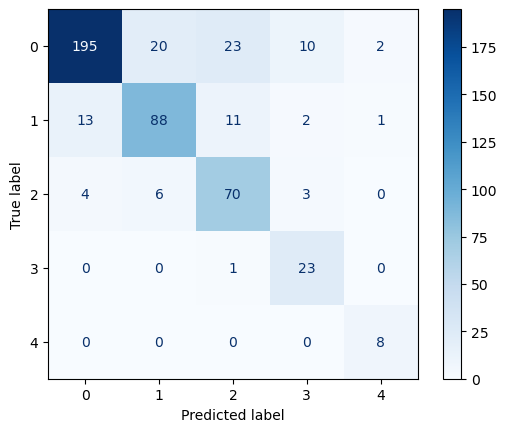

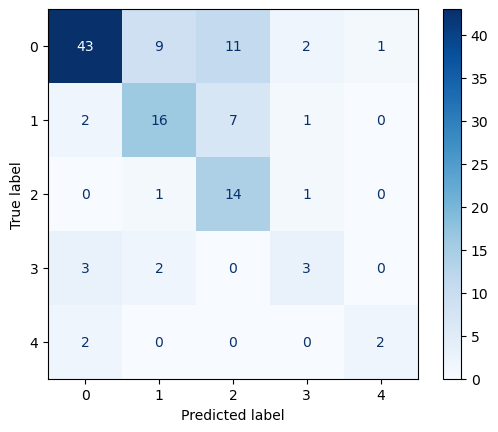

In [35]:
# print('train: ',xgboostModel_twostage.score(x_train, y_train))
pred = xgboostModel_twostage.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train, pred)).plot(cmap='Blues')
results_recall = recall_score(y_train, pred, average=None)
print("Training UAR(Unweighted Average Recall) :", results_recall.mean())

# print('test: ',xgboostModel_twostage.score(x_test, y_test))
pred = xgboostModel_twostage.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot(cmap='Blues')
results_recall = recall_score(y_test, pred, average=None)
print("Testing UAR(Unweighted Average Recall) :", results_recall.mean())

In [36]:
from collections import Counter
Counter(pred)

Counter({0: 50, 3: 7, 2: 32, 4: 3, 1: 28})

## xgboost public

In [39]:
import numpy as np
def inference2(model, val_dl): 
    correct_prediction = 0 
    total_prediction = 0 
    ls = []
    # Disable gradient updates 
    with torch.no_grad(): 
        for data in val_dl: 
            # Get the input features and target labels, and put them on the GPU 
            inputs = data

            # Normalize the inputs 
            inputs_m, inputs_s = inputs.mean(), inputs.std() 
            inputs = (inputs - inputs_m) / inputs_s 

            # Get predictions 
            # print(inputs)
            outputs = model(inputs) 

            # Get the predicted class with the highest score 
            _, prediction = torch.max(outputs,1) 
            p = prediction.tolist()
            ls.append(prediction)
            return ls
    # Run inference on trained model with the validation set 

In [40]:
# 讀取訓練資料集表單
public_df = pd.read_csv('Public Testing Dataset/test_datalist_public.csv')
public_df['wav_path'] = public_df['ID'].map("Public Testing Dataset/test_data_public/{}.wav".format)

In [41]:
df = public_df[['wav_path']]
df = df.reset_index()
train_data_for_ac = SoundDS(df, data_path, mode='public')
train_data_for_ac = torch.utils.data.DataLoader(train_data_for_ac, batch_size=750, shuffle=False)
ac_ls = inference2(myModel, train_data_for_ac)
ac_ls = ac_ls[0].tolist()

col = [i for i in public_df.columns if i not in ['ID', 'wav_path']]
test_data_for_med = public_df[col]
pred_ls = med_model.predict(test_data_for_med)

In [42]:
df_new = public_df
dfac = pd.DataFrame(ac_ls, columns = ['aco_pred'])
dfmd = pd.DataFrame(pred_ls, columns = ['med_pred'])

import pandas as pd
result = pd.concat([df_new, dfac , dfmd ],axis=1)

In [43]:
col = [i for i in result.columns if i not in ['ID','Disease category','wav_path']]
x_train = result[col]

In [44]:
pred = xgboostModel_twostage.predict(x_train)

In [45]:
category = pred+1
idn = public_df['ID']
dfc = pd.DataFrame(idn, columns = ['ID'])
import pandas as pd
result = pd.concat([dfc, pd.DataFrame(category, columns = ['Category'])], axis=1)
result.to_csv('out5.csv', index=False)

## private

In [47]:
private_df = pd.read_csv('Private Testing Dataset/test_datalist_private.csv')
private_df['wav_path'] = private_df['ID'].map("Private Testing Dataset/test_data_private/{}.wav".format)

In [48]:
df1 = private_df[['wav_path']]
df1 = df1.reset_index()
train_data_for_ac1 = SoundDS(df1, data_path, mode='private')
train_data_for_ac1 = torch.utils.data.DataLoader(train_data_for_ac1, batch_size=750, shuffle=False)
ac_ls1 = inference2(myModel, train_data_for_ac1)
ac_ls1 = ac_ls1[0].tolist()

col1 = [i for i in private_df.columns if i not in ['ID', 'wav_path']]
test_data_for_med1 = private_df[col1]
pred_ls1 = med_model.predict(test_data_for_med1)

In [49]:
df_new1 = private_df
dfac1 = pd.DataFrame(ac_ls1, columns = ['aco_pred'])
dfmd1 = pd.DataFrame(pred_ls1, columns = ['med_pred'])

import pandas as pd
result1= pd.concat([df_new1, dfac1 , dfmd1 ],axis=1)

In [50]:
col1 = [i for i in result1.columns if i not in ['ID','Disease category','wav_path']]
x_train1 = result1[col1]

In [51]:
pred1 = xgboostModel_twostage.predict(x_train1)

In [52]:
category1 = pred1+1
idn1 = private_df['ID']
dfc1 = pd.DataFrame(idn1, columns = ['ID'])
import pandas as pd
result1 = pd.concat([dfc1, pd.DataFrame(category1, columns = ['Category'])], axis=1)
# result.to_csv('out5.csv', index=False)

In [53]:
result1

,ID,Category
0,0U02g8u,2
1,0Y00jid,4
2,0R02296,4
3,0W016c9,4
4,11006gd,3
...,...,...
495,1001abu,1
496,1002ss4,3
497,0W011bi,1
498,0R00num,3


In [54]:
result2=pd.concat([result,result1],axis=0, ignore_index=True)
result2

,ID,Category
0,1301skj,1
1,1100j0u,4
2,0G00r5c,3
3,1202v5m,1
4,0C01365,3
...,...,...
995,1001abu,1
996,1002ss4,3
997,0W011bi,1
998,0R00num,3


In [55]:
result2.to_csv('two_stage_pub_pri_test5.csv', index=False)

In [56]:
from collections import Counter
Counter(result2['Category'])

Counter({1: 475, 4: 95, 3: 208, 2: 200, 5: 22})